In [1]:
p = np.array([math.sin(x/2)+x/16 for x in range(30)]) + 3# + (np.random.random(L)-0.5)*2
p = torch.from_numpy(p.astype(np.float32))*10
dp = p[1:] - p[:-1]
hold = compute_hold(p)
plt.plot(p, ".-")
plt.plot(hold)
plt.plot(dp)

fsize = 3
features = []
for i in range(p.shape[0]):
    if i < fsize-1:
        features.append(torch.zeros(fsize))
    else:
        features.append(p[i-fsize+1:i+1] - p[i])

features = torch.vstack(features)
for i in range(fsize-1, 10):
    plt.plot(range(i-fsize+1, i+1), features[i].numpy())
plt.grid("on")
plt.tight_layout()

NameError: name 'np' is not defined

In [38]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import PyConfig
from data_processing.train_dataset import next_price_prediction
from tqdm import tqdm
from ml.models import autoregress_sequense, E2EModel
from e2e_train import E2ETrain
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from backtest import backtest

%reload_ext autoreload
%autoreload 2

def save_model(model):
    model.eval()
    example = torch.rand((1,) + model.inp_shape)
    model_jit = torch.jit.trace(model, example)
    model_jit.save("model.pt")

    # torch.save(model, "model.pt")

In [50]:
DEVICE = torch.device("cpu")
cfg = PyConfig("zz.py").test()

/Users/andrybin/miniforge3/lib/python3.10/site-packages/torch/serialization.py:799: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [6]:
e2e_train = E2ETrain(cfg)
e2e_train.load_data(500)

(500, 10) (500,)


In [18]:
model = e2e_train.train(num_epochs=100, 
                        resume=True,
                        device=DEVICE)

Training: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


<BarContainer object of 4612 artists>

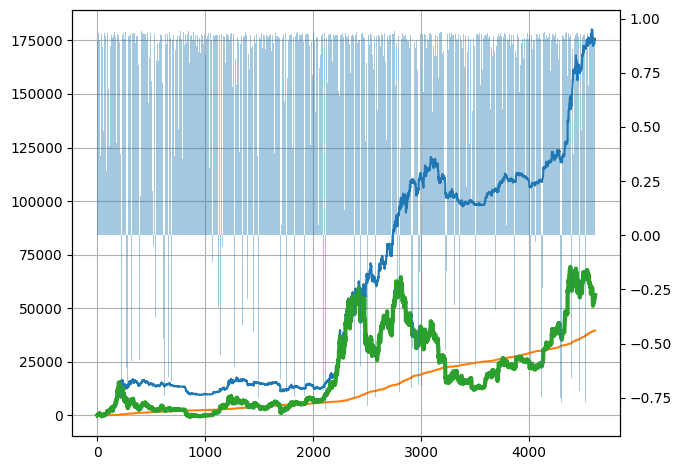

In [19]:
model.eval()
output_seq, result_seq, fee_seq = autoregress_sequense(model, e2e_train.p, e2e_train.features, output_sequense=True, device=DEVICE)

fig, ax1 = plt.subplots()
# ax1.plot(p - p[0], linewidth=3)
ax1.plot(result_seq.cumsum(0))
ax1.plot(fee_seq.cumsum(0))
ax1.plot(e2e_train.compute_hold(), linewidth=3)
ax1.grid("on")
plt.tight_layout()
plt.grid("on")

ax2 = ax1.twinx()
ax2.bar(list(range(output_seq.shape[0])), height=output_seq, width=1, alpha=0.4)

In [10]:
with torch.no_grad():   
    model = torch.load("model.pt")
    output = model(torch.from_numpy(e2e_train.features[300:301]))
output

tensor([[0.7836]])

(4392, 10) (4392,)
Layer (type:depth-idx)                   Output Shape              Param #
E2EModel                                 [1, 1]                    --
├─LayerNorm: 1-1                         [1, 10]                   20
├─Linear: 1-2                            [1, 8]                    88
├─InstanceNorm1d: 1-3                    [1, 8]                    --
├─ReLU: 1-4                              [1, 8]                    --
├─Linear: 1-5                            [1, 8]                    72
├─InstanceNorm1d: 1-6                    [1, 8]                    --
├─ReLU: 1-7                              [1, 8]                    --
├─Linear: 1-8                            [1, 1]                    9
├─Tanh: 1-9                              [1, 1]                    --
Total params: 189
Trainable params: 189
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Training: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]
2024-08-06 23:11:52.534 | INFO     | backtest:backtest:251 - BTCUSDT-M60: zigzag:None-10-8, sl=stops_dyn:False-False, sl-rate=0.003
2024-08-06 23:11:52.534 | INFO     | backtest:backtest:252 -                 total backtest: 36.38 sec
2024-08-06 23:11:52.535 | INFO     | backtest:backtest:253 -                  data loadings:     1 %
2024-08-06 23:11:52.535 | INFO     | backtest:backtest:254 -                 expert updates:    91 %
2024-08-06 23:11:52.535 | INFO     | backtest:backtest:255 -                 broker updates:     1 %
2024-08-06 23:11:52.536 | INFO     | backtest:backtest:256 -               postproc. broker:     0 %
2024-08-06 23:11:52.536 | INFO     | backtest:backtest:258 -                     Buy & Hold:     6 %
2024-08-06 23:11:52.536 | INFO     | backtest:backtest:260 - ----------------------------------------
/Users/andrybin/Dev/MLTR/backtest.py:89: RuntimeWarning: invalid value encountered in scalar divide
  

(4392, 10) (4392,)
Layer (type:depth-idx)                   Output Shape              Param #
E2EModel                                 [1, 1]                    --
├─LayerNorm: 1-1                         [1, 10]                   20
├─Linear: 1-2                            [1, 8]                    88
├─InstanceNorm1d: 1-3                    [1, 8]                    --
├─ReLU: 1-4                              [1, 8]                    --
├─Linear: 1-5                            [1, 8]                    72
├─InstanceNorm1d: 1-6                    [1, 8]                    --
├─ReLU: 1-7                              [1, 8]                    --
├─Linear: 1-8                            [1, 1]                    9
├─Tanh: 1-9                              [1, 1]                    --
Total params: 189
Trainable params: 189
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Training: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]
2024-08-06 23:13:03.853 | INFO     | backtest:backtest:251 - BTCUSDT-M60: zigzag:None-10-8, sl=stops_dyn:False-False, sl-rate=0.003
2024-08-06 23:13:03.854 | INFO     | backtest:backtest:252 -                 total backtest: 30.82 sec
2024-08-06 23:13:03.854 | INFO     | backtest:backtest:253 -                  data loadings:     1 %
2024-08-06 23:13:03.855 | INFO     | backtest:backtest:254 -                 expert updates:    91 %
2024-08-06 23:13:03.855 | INFO     | backtest:backtest:255 -                 broker updates:     1 %
2024-08-06 23:13:03.855 | INFO     | backtest:backtest:256 -               postproc. broker:     0 %
2024-08-06 23:13:03.856 | INFO     | backtest:backtest:258 -                     Buy & Hold:     6 %
2024-08-06 23:13:03.856 | INFO     | backtest:backtest:260 - ----------------------------------------
/Users/andrybin/Dev/MLTR/backtest.py:89: RuntimeWarning: invalid value encountered in scalar divide
  

(4392, 10) (4392,)
Layer (type:depth-idx)                   Output Shape              Param #
E2EModel                                 [1, 1]                    --
├─LayerNorm: 1-1                         [1, 10]                   20
├─Linear: 1-2                            [1, 8]                    88
├─InstanceNorm1d: 1-3                    [1, 8]                    --
├─ReLU: 1-4                              [1, 8]                    --
├─Linear: 1-5                            [1, 8]                    72
├─InstanceNorm1d: 1-6                    [1, 8]                    --
├─ReLU: 1-7                              [1, 8]                    --
├─Linear: 1-8                            [1, 1]                    9
├─Tanh: 1-9                              [1, 1]                    --
Total params: 189
Trainable params: 189
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Training: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


KeyboardInterrupt: 

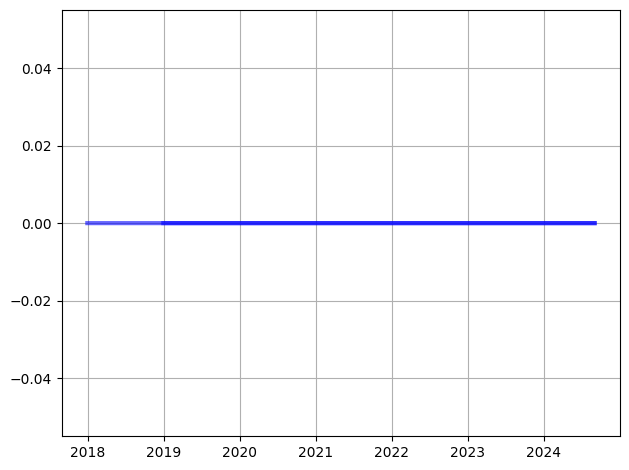

In [54]:
date_start = datetime.strptime(cfg.date_start, '%Y-%m-%dT%H:%M:%S').strftime('%m/%d/%Y')
date_end = datetime.strptime(cfg.date_end, '%Y-%m-%dT%H:%M:%S').strftime('%m/%d/%Y')

years = [pd.to_datetime(d).date() for d in 
         pd.date_range(start=date_start, end=date_end, freq="Y")]

date_start = cfg.date_start
last_prof = 0
for year in years:
    cfg.date_start = date_start
    cfg.date_end = year.strftime('%Y-%m-%dT%H:%M:%S')
    e2e_train = E2ETrain(cfg)
    e2e_train.load_data()
    model = e2e_train.train(num_epochs=5, resume=False, device=DEVICE)
    save_model(model)
    
    cfg.date_start = cfg.date_end
    cfg.date_end = "2024-09-01T00:00:00"
    brok_results = backtest(cfg)

    plt.plot(brok_results.daily_hist.days, brok_results.daily_hist.profit + last_prof, linewidth=3, color="b", alpha=0.6)
    last_prof += brok_results.final_profit
    plt.grid("on")
    plt.tight_layout()
    # legend.append(f"{cfg.date_start}-{cfg.date_end}")

In [47]:
brok_results.daily_hist.profit + 1000


0       993.248699
1       996.931971
2       996.931971
3       996.931971
4       996.931971
           ...    
2432    260.168632
2433    260.168632
2434    260.168632
2435    260.168632
2436    260.168632
Name: profit, Length: 2437, dtype: float64